In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision
!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316
Receiving objects: 100% (500/500), 9.45 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [4]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

## Konfigurasi dan Load Pre-trained Model

In [5]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [6]:
# Set random seed
set_seed(19072021) #untuk memudahkan gunakan tanggal saat membuat proyek

In [7]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
count_param(model)

124443651

In [10]:
# import torch
# from transformers import BertForSequenceClassification, BertTokenizer
# from torchviz import make_dot

# # Load Tokenizer
# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# # Instantiate model
# model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')

# # Create a dummy input tensor
# dummy_input = torch.randint(low=0, high=tokenizer.vocab_size, size=(1, 64))  # Assuming input size of (1, 64)

# # Get the model without the final classifier layer
# model_without_classifier = model.bert

# # Forward pass to get the model graph
# outputs = model_without_classifier(dummy_input)

# # Visualize the model graph
# dot = make_dot(outputs[0], params=dict(model.named_parameters()))
# dot.format = 'png'
# dot.render(filename='bert_model_structure', directory='./', cleanup=True)

# Load IndoNLU Dataset

In [11]:
train_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'
test_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/test_preprocess_masked_label.tsv'

In [12]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [14]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (52.480%)


# Training Dataset IndoNLU

In [15]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [16]:
# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 1) TRAIN LOSS:0.3364 LR:0.00000300: 100%|██████████| 344/344 [02:45<00:00,  2.08it/s]


(Epoch 1) TRAIN LOSS:0.3364 ACC:0.87 F1:0.83 REC:0.80 PRE:0.87 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
VALID LOSS:0.1967 ACC:0.92 F1:0.89 REC:0.89 PRE:0.90: 100%|██████████| 40/40 [00:08<00:00,  4.62it/s]


(Epoch 1) VALID LOSS:0.1967 ACC:0.92 F1:0.89 REC:0.89 PRE:0.90


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 2) TRAIN LOSS:0.1583 LR:0.00000300: 100%|██████████| 344/344 [02:43<00:00,  2.10it/s]


(Epoch 2) TRAIN LOSS:0.1583 ACC:0.94 F1:0.93 REC:0.92 PRE:0.93 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
VALID LOSS:0.1637 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


(Epoch 2) VALID LOSS:0.1637 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 3) TRAIN LOSS:0.1174 LR:0.00000300: 100%|██████████| 344/344 [02:45<00:00,  2.52it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multith

(Epoch 3) TRAIN LOSS:0.1174 ACC:0.96 F1:0.95 REC:0.95 PRE:0.95 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
VALID LOSS:0.1679 ACC:0.94 F1:0.91 REC:0.91 PRE:0.91:  98%|█████████▊| 39/40 [00:07<00:00,  5.51it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is

(Epoch 3) VALID LOSS:0.1679 ACC:0.94 F1:0.91 REC:0.91 PRE:0.91


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 4) TRAIN LOSS:0.0885 LR:0.00000300: 100%|██████████| 344/344 [02:43<00:00,  2.16it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multith

(Epoch 4) TRAIN LOSS:0.0885 ACC:0.97 F1:0.96 REC:0.96 PRE:0.97 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
VALID LOSS:0.1777 ACC:0.94 F1:0.92 REC:0.91 PRE:0.93: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]


(Epoch 4) VALID LOSS:0.1777 ACC:0.94 F1:0.92 REC:0.91 PRE:0.93


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 5) TRAIN LOSS:0.0661 LR:0.00000300: 100%|██████████| 344/344 [02:44<00:00,  2.10it/s]


(Epoch 5) TRAIN LOSS:0.0661 ACC:0.98 F1:0.98 REC:0.97 PRE:0.98 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
VALID LOSS:0.1852 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

(Epoch 5) VALID LOSS:0.1852 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92


In [17]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


     index     label
0        0  negative
1        1  negative
2        2  negative
3        3  negative
4        4  negative
..     ...       ...
495    495   neutral
496    496   neutral
497    497  positive
498    498  positive
499    499  positive

[500 rows x 2 columns]


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 88%|████████▊ | 14/16 [00:03<00:00, 10.43it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

In [18]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (99.394%)


# Load Data Kendaraan Listrik

In [19]:
data = pd.read_excel('/content/drive/MyDrive/Tugas Akhir/data_jurnal/dataset_twitter-scraper_2024-02-13_03-10-16-077.xlsx')

In [20]:
selected_data = data[['full_text']]

# Preprocessing Data

In [21]:
stopwords = ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'setelah', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'apakah', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 'sebetulnya', 'setiap', 'setidaknya', 'sesuatu', 'pasti', 'saja', 'toh', 'ya', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun', 'sekali', 'jadi', 'nya']
keep_stopwords = ['tidak', 'sementara', 'belum', 'tetapi', 'kecuali', 'tapi', 'ada', 'tanpa', 'nggak', 'ok', 'hanya', 'kurang']
fix_stopwords = [next if word in keep_stopwords else word for word in stopwords]

In [22]:
words_dict = {
    'tdk'  : 'tidak',
    'yg' : 'yang',
    'ga' : 'tidak',
    'gak' : 'tidak',
    'tp' : 'tapi',
    'd' : 'di',
    'sy' : 'saya',
    '&' : 'dan',
    'dgn' : 'dengan',
    'utk' : 'untuk',
    'gk' : 'tidak',
    'jd' : 'jadi',
    'jg' : 'juga',
    'dr' : 'dari',
    'krn' : 'karena',
    'aja' : 'saja',
    'karna' : 'karena',
    'udah' : 'sudah',
    'kmr' : 'kamar',
    'g' : 'tidak',
    'dpt' : 'dapat',
    'banget' : 'sekali',
    'bgt' : 'sekali',
    'kalo' : 'kalau',
    'n' : 'dan',
    'bs' : 'bisa',
    'oke' : 'ok',
    'dg' : 'dengan',
    'pake' : 'pakai',
    'sampe' : 'sampai',
    'dapet' : 'dapat',
    'ad' : 'ada',
    'lg' : 'lagi',
    'bikin' : 'buat',
    'tak' : 'tidak',
    'ny' : 'nya',
    'ngga' : 'tidak',
    'nunggu' : 'tunggu',
    'klo' : 'kalau',
    'blm' : 'belum',
    'trus' : 'terus',
    'kayak' : 'seperti',
    'dlm' : 'dalam',
    'udh' : 'sudah',
    'tau' : 'tahu',
    'org' : 'orang',
    'hrs' : 'harus',
    'msh' : 'masih',
    'sm' : 'sama',
    'byk' : 'banyak',
    'krg' : 'kurang',
    'kmar' : 'kamar',
    'spt' : 'seperti',
    'pdhl' : 'padahal',
    'chek' : 'cek',
    'pesen' : 'pesan',
    'kran' : 'keran',
    'gitu' : 'begitu',
    'tpi' : 'tapi',
    'lbh' : 'lebih',
    'tmpt' : 'tempat',
    'dikasi' : 'dikasih',
    'serem' : 'seram',
    'sya' : 'saya',
    'jgn' : 'jangan',
    'dri' : 'dari',
    'dtg' : 'datang',
    'gada' : 'tidak ada',
    'standart' : 'standar',
    'mlm' : 'malam',
    'k'  : 'ke',
    'kl' : 'kalau',
    'sgt': 'sangat',
    'y' : 'ya',
    'krna' : 'karena',
    'tgl' : 'tanggal',
    'terimakasih' : 'terima kasih',
    'kecoak' : 'kecoa',
    'pd' : 'pada',
    'tdr' : 'tidur',
    'jdi' : 'jadi',
    'kyk' : 'seperti',
    'sdh' : 'sudah',
    'ama' : 'sama',
    'gmana' : 'bagaimana',
    'dalem' : 'dalam',
    'tanyak' : 'tanya',
    'taru' : 'taruh',
    'gede' : 'besar',
    'kaya' : 'seperti',
    'access' : 'akses',
    'tetep' : 'tetap',
    'mgkin' : 'mungkin',
    'sower' : 'shower',
    'idup' : 'hidup',
    'nyaaa' : 'nya',
    'baikk' : 'baik',
    'hanay' : 'hanya',
    'tlp' : 'telpon',
    'kluarga' : 'keluarga',
    'jln' : 'jalan',
    'hr' : 'hari',
    'ngak' : 'tidak',
    'bli' : 'beli',
    'kmar' : 'kamar',
    'naro' : 'taruh',
    'gaada' : 'tidak ada'
}

In [23]:
import re
import string

selected_data['full_text_cleaned'] = [i.lower() for i in selected_data['full_text']]

# removing \x00 characters
selected_data['full_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in selected_data['full_text_cleaned']]

#r removing \n
selected_data['full_text_cleaned'] = [re.sub(r'\n', r' ', i) for i in selected_data['full_text_cleaned']]

#r removing numbers
selected_data['full_text_cleaned'] = [re.sub(r"\d+", r"", i) for i in selected_data['full_text_cleaned']]

#removing punctuation
selected_data['full_text_cleaned'] = [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in selected_data['full_text_cleaned']]

def num_count(data, feature) :
    #kompas_list = list(set(kompas['words']))
    num_list = []
    for sentence in tqdm(data[feature]) :
        num = 0
        for word in sentence :
            if word.isdigit() :
                num += 1
            else :
                num += 0
        num_list.append(num)
    return num_list

selected_data['num_of_space'] = [i.count(' ') for i in selected_data['full_text_cleaned']]

selected_data['num_of_words'] = [len(i.split()) for i in selected_data['full_text_cleaned']]

selected_data['num_unique_char'] = [len(set(i)) for i in selected_data['full_text_cleaned']]

selected_data['len_string_initial'] = [len(i) for i in selected_data['full_text']]

selected_data['num_of_numeric'] = num_count(selected_data, 'full_text')

<ipython-input-23-a69adeaeb507>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = [i.lower() for i in selected_data['full_text']]
<ipython-input-23-a69adeaeb507>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in selected_data['full_text_cleaned']]
<ipython-input-23-a69adeaeb507>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [24]:
def remove_indonesian_stop(data, feature) :
    stopwords = fix_stopwords
    filtered = []
    for text in data[feature] :
        text_list = []
        for word in text.split() :
            if word not in stopwords :
                text_list.append(word)
        text_list = ' '.join(text_list)
        filtered.append(text_list)
    return filtered

In [25]:
list_sentence_selected_data = []
for sentence in tqdm(selected_data['full_text_cleaned']) :
    cleaned_sentence = [words_dict[word] if word in list(words_dict.keys()) else word for word in sentence.split()]
    list_sentence_selected_data.append(' '.join(cleaned_sentence))
selected_data['full_text_cleaned'] = list_sentence_selected_data

#removing indonesian stopwords
selected_data['full_text_cleaned_nostopwords'] = remove_indonesian_stop(selected_data, 'full_text_cleaned')

100%|██████████| 1000/1000 [00:00<00:00, 18394.70it/s]
<ipython-input-25-00192d9cd00f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = list_sentence_selected_data
<ipython-input-25-00192d9cd00f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned_nostopwords'] = remove_indonesian_stop(selected_data, 'full_text_cleaned')


# Labeling Data

In [26]:
# Fungsi untuk mengonversi label angka menjadi label teks
def convert_label_to_text(label):
    return i2w[label]

# Fungsi untuk melakukan pelabelan pada teks
def label_text(text):
    # Tokenisasi teks
    subwords = tokenizer.encode(text)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    # Prediksi label
    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

    return convert_label_to_text(label)

# Membuat kolom baru untuk menyimpan hasil pelabelan
selected_data['sentiment'] = ''

# Melabelkan setiap teks pada kolom full_text dan menambahkan hasil pelabelan ke kolom baru
for index, row in selected_data.iterrows():
    text = row['full_text_cleaned_nostopwords']
    label = label_text(text)
    selected_data.at[index, 'sentiment'] = label

<ipython-input-26-06f92445d5ae>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['sentiment'] = ''


In [27]:
selected_data.head()

,full_text,full_text_cleaned,num_of_space,num_of_words,num_unique_char,len_string_initial,num_of_numeric,full_text_cleaned_nostopwords,sentiment
0,Gibran Rakabuming Raka mengendarai motor sport...,gibran rakabuming raka mengendarai motor sport...,46,35,23,301,7,gibran rakabuming raka mengendarai motor sport...,neutral
1,apa perlu w jual motor trs ganti motor listrik,apa perlu w jual motor trs ganti motor listrik,9,9,17,47,0,apa perlu w jual motor trs ganti motor listrik,neutral
2,Driver ojek online (ojol) yang menggunakan mot...,driver ojek online ojol yang menggunakan motor...,27,23,24,163,1,driver ojek online ojol menggunakan motor list...,neutral
3,kenapa ya jok motor listrik tuh gaada yang ena...,kenapa ya jok motor listrik tuh tidak ada yang...,14,15,20,78,0,jok motor listrik tuh tidak ada enak masa rata...,negative
4,Alva Siap Rilis Motor Listrik Baru di IIMS 202...,alva siap rilis motor listrik baru di iims ada...,20,16,21,93,8,alva siap rilis motor listrik baru iims ada di...,neutral


In [28]:
modeling_data = selected_data[['full_text_cleaned_nostopwords', 'sentiment']]

In [29]:
modeling_data.rename(columns={'full_text_cleaned_nostopwords': 'text'}, inplace=True)

<ipython-input-29-855651eb642b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_data.rename(columns={'full_text_cleaned_nostopwords': 'text'}, inplace=True)


In [30]:
modeling_data

,text,sentiment
0,gibran rakabuming raka mengendarai motor sport...,neutral
1,apa perlu w jual motor trs ganti motor listrik,neutral
2,driver ojek online ojol menggunakan motor list...,neutral
3,jok motor listrik tuh tidak ada enak masa rata...,negative
4,alva siap rilis motor listrik baru iims ada di...,neutral
...,...,...
995,memasuki musim hujan pengemudi mobil lebih ber...,neutral
996,menteri bumn erick thohir mengatakan penggunaa...,neutral
997,kali giliran pejabat eselon i ii lingkungan ke...,neutral
998,wuiiih asik bener kementerian badan usaha mili...,neutral


# EDA

In [31]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

In [32]:
# Melihat nilai unik dan jumlahnya pada kolom 'sentiment'
sentiment_counts = selected_data['sentiment'].value_counts()
sentiment_counts

sentiment
neutral     640
positive    187
negative    173
Name: count, dtype: int64

<ipython-input-33-e9ab9f3ba1f2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=selected_data, x='sentiment', palette=colors)


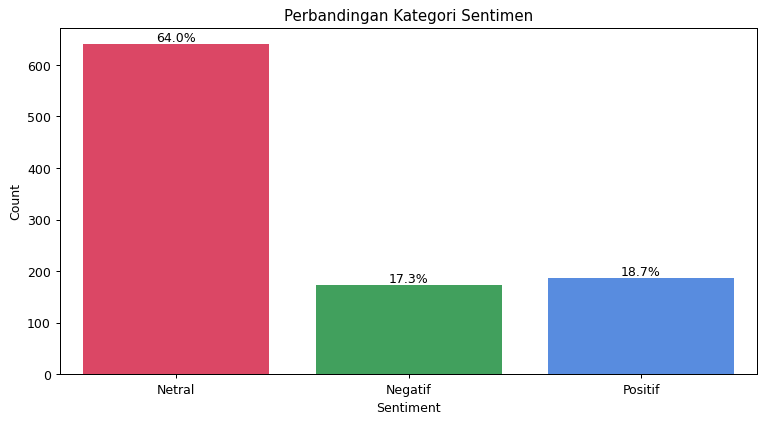

In [33]:
# selected_data.groupby('sentiment').size().plot(kind='bar')

import seaborn as sns
import matplotlib.pyplot as plt

# Define colors
colors = ['#F42E56', '#31B057', '#4287f5']  # Red, Green, Blue

# Plot using Seaborn
plt.figure(figsize=(10, 5), dpi=90)
ax = sns.countplot(data=selected_data, x='sentiment', palette=colors)

# Set labels for each category
plt.xticks([0, 1, 2], ['Netral', 'Negatif', 'Positif'])

# Add percentage text
total = len(selected_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Set title and labels
plt.title('Perbandingan Kategori Sentimen')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()

In [34]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

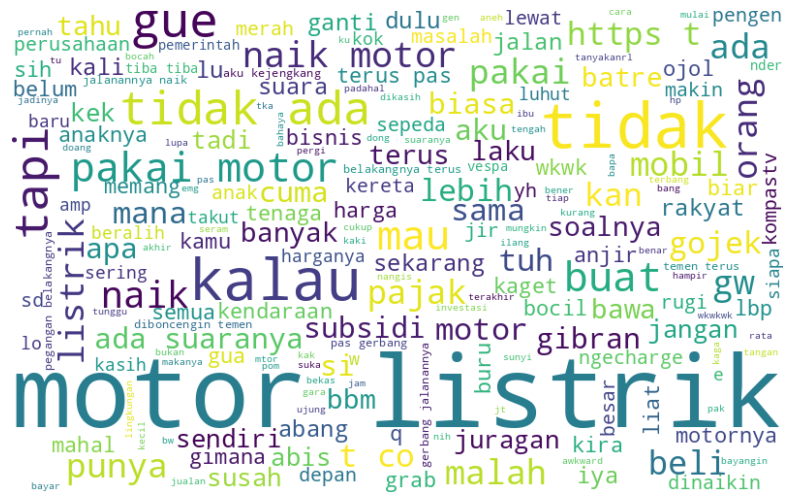

In [35]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'negative'])
wordCloud(negative_words)

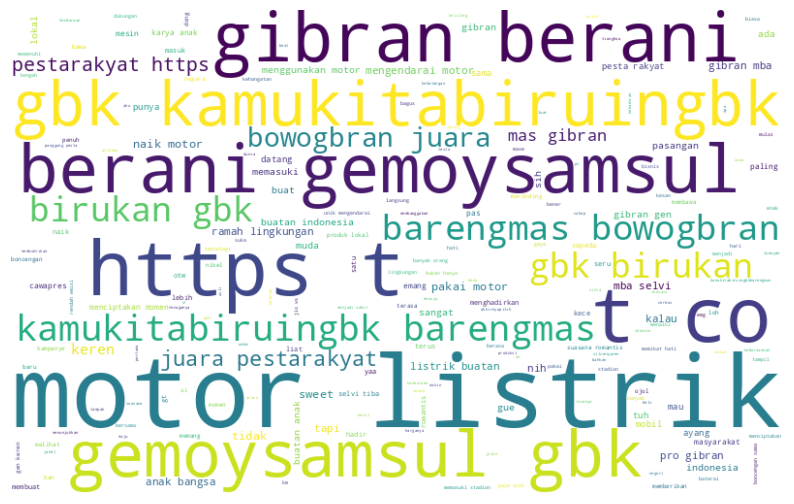

In [36]:
# Melihat kata-kata yang negatif
positive_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'positive'])
wordCloud(positive_words)

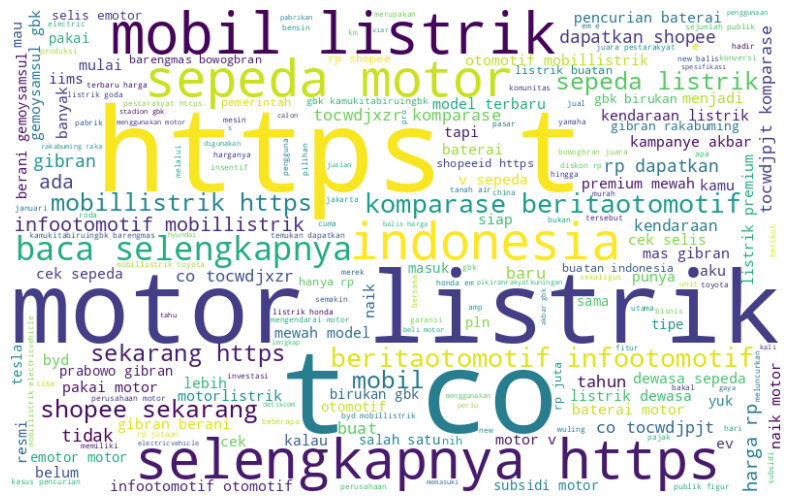

In [37]:
# Melihat kata-kata yang negatif
neutral_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'neutral'])
wordCloud(neutral_words)

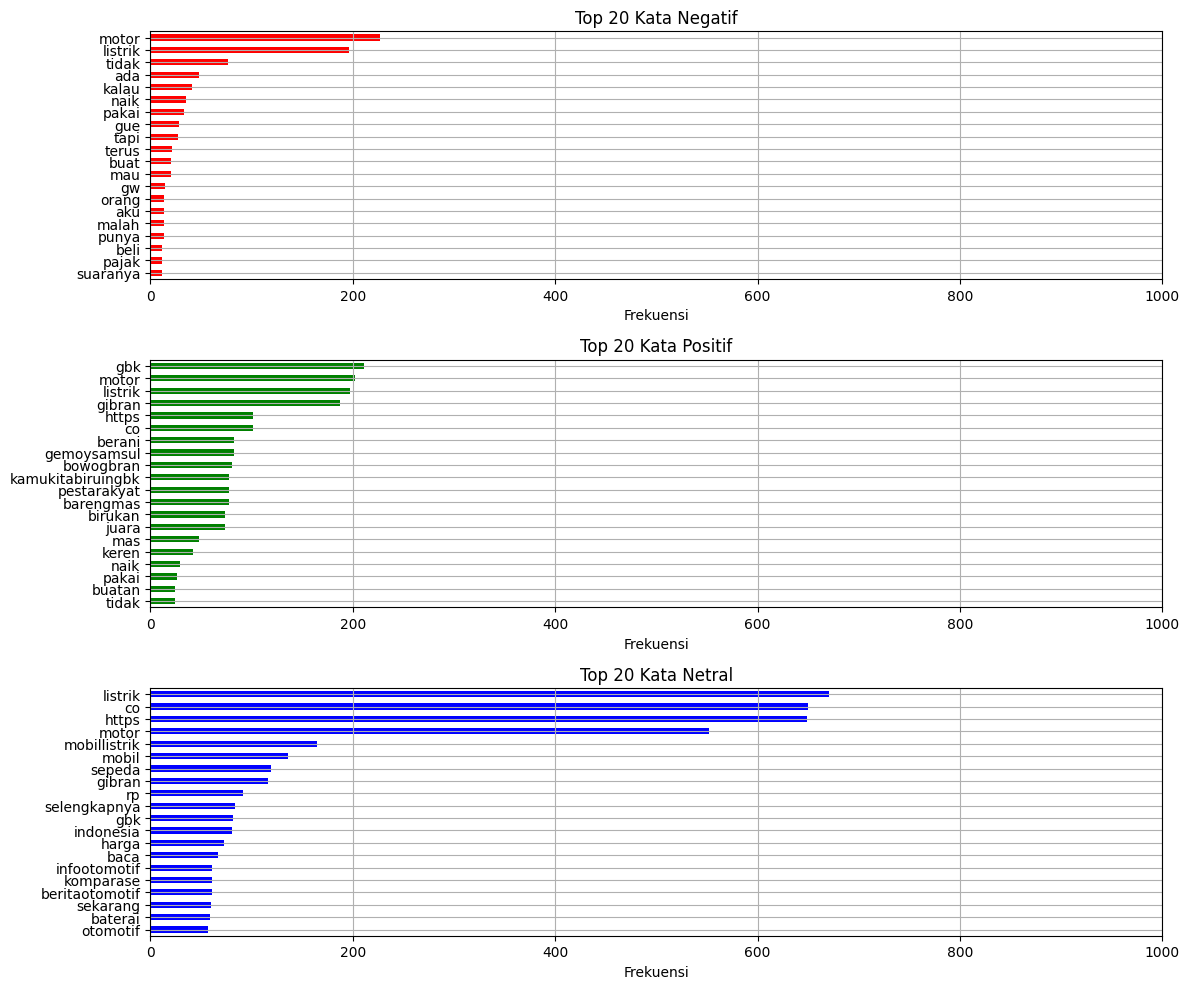

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Membuat CountVectorizer dengan max_features=1000
cv = CountVectorizer(max_features=1000)

# Mengubah teks menjadi vektor fitur
X = cv.fit_transform(modeling_data['text'])

# Membuat DataFrame untuk memudahkan pengolahan data
word_freq_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

# Menambahkan kolom sentimen ke DataFrame
word_freq_df['sentiment'] = modeling_data['sentiment'].values

# Memilih hanya kata-kata yang sesuai dengan kategori sentimen
negative_words_df = word_freq_df[word_freq_df['sentiment'] == 'negative'].drop(columns=['sentiment'])
positive_words_df = word_freq_df[word_freq_df['sentiment'] == 'positive'].drop(columns=['sentiment'])
neutral_words_df = word_freq_df[word_freq_df['sentiment'] == 'neutral'].drop(columns=['sentiment'])

# Menghitung total frekuensi kemunculan kata-kata untuk setiap kategori
negative_word_freq = negative_words_df.sum(axis=0)
positive_word_freq = positive_words_df.sum(axis=0)
neutral_word_freq = neutral_words_df.sum(axis=0)

# Mengurutkan berdasarkan frekuensi kemunculan kata-kata
top_negative_words = negative_word_freq.sort_values(ascending=False)[:20]
top_positive_words = positive_word_freq.sort_values(ascending=False)[:20]
top_neutral_words = neutral_word_freq.sort_values(ascending=False)[:20]

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
top_negative_words.sort_values().plot(kind='barh', color='red')
plt.title('Top 20 Kata Negatif')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.subplot(3, 1, 2)
top_positive_words.sort_values().plot(kind='barh', color='green')
plt.title('Top 20 Kata Positif')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.subplot(3, 1, 3)
top_neutral_words.sort_values().plot(kind='barh', color='blue')
plt.title('Top 20 Kata Netral')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.tight_layout()
plt.show()

# Split Data

In [39]:
from sklearn.model_selection import train_test_split

# Bagi data menjadi train dan sisanya (validasi + pengujian)
train_data, remaining_data = train_test_split(modeling_data, test_size=0.2, random_state=42)

# Bagi sisa data menjadi set validasi dan pengujian
valid_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

# Periksa ukuran setiap set
print("Jumlah data pelatihan:", len(train_data))
print("Jumlah data validasi:", len(valid_data))
print("Jumlah data pengujian:", len(test_data))

Jumlah data pelatihan: 800
Jumlah data validasi: 100
Jumlah data pengujian: 100


In [40]:
# Save train_data to TSV
train_data.to_csv('train_data.tsv', sep='\t', index=False, header=False)

# Save valid_data to TSV
valid_data.to_csv('valid_data.tsv', sep='\t', index=False, header=False)

# Save test_data to TSV
test_data.to_csv('test_data.tsv', sep='\t', index=False, header=False)

In [41]:
train_dataset_path = 'train_data.tsv'
valid_dataset_path = 'valid_data.tsv'
test_dataset_path = 'test_data.tsv'

In [42]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [44]:
# Train
# Lists to store training and validation loss
train_losses = []
valid_losses = []

# Lists to store evaluation metrics
train_metrics_list = []
valid_metrics_list = []

n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    train_metrics_list.append(metrics)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss += valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

        pbar.set_description("VALID LOSS:{:.4f}".format(total_loss/(i+1)))

    # Calculate validation metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    valid_metrics_list.append(metrics)

    # Append losses
    train_losses.append(total_train_loss / len(train_loader))
    valid_losses.append(total_loss / len(valid_loader))

    print("(Epoch {}) TRAIN LOSS:{:.4f} {}".format((epoch+1), total_train_loss/len(train_loader), metrics_to_string(train_metrics_list[-1])))
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1), total_loss/len(valid_loader), metrics_to_string(valid_metrics_list[-1])))

  0%|          | 0/25 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.p

(Epoch 1) TRAIN LOSS:0.1394 ACC:0.95 F1:0.93 REC:0.93 PRE:0.92
(Epoch 1) VALID LOSS:0.0855 ACC:0.96 F1:0.95 REC:0.95 PRE:0.95


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is sm

(Epoch 2) TRAIN LOSS:0.0774 ACC:0.97 F1:0.96 REC:0.97 PRE:0.96
(Epoch 2) VALID LOSS:0.0809 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 3) TRAIN LOSS:0.0530 LR:0.00000300: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithrea

(Epoch 3) TRAIN LOSS:0.0530 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98
(Epoch 3) VALID LOSS:0.0478 ACC:0.99 F1:0.99 REC:0.98 PRE:0.99


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 4) TRAIN LOSS:0.0346 LR:0.00000300: 100%|██████████| 25/25 [00:10<00:00,  2.87it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithrea

(Epoch 4) TRAIN LOSS:0.0346 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99
(Epoch 4) VALID LOSS:0.1231 ACC:0.95 F1:0.95 REC:0.97 PRE:0.93


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is sm

(Epoch 5) TRAIN LOSS:0.0382 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99
(Epoch 5) VALID LOSS:0.0531 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99


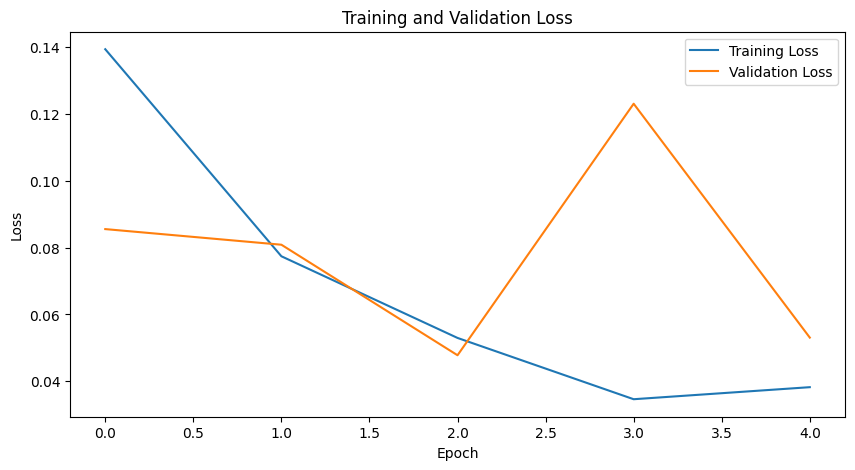

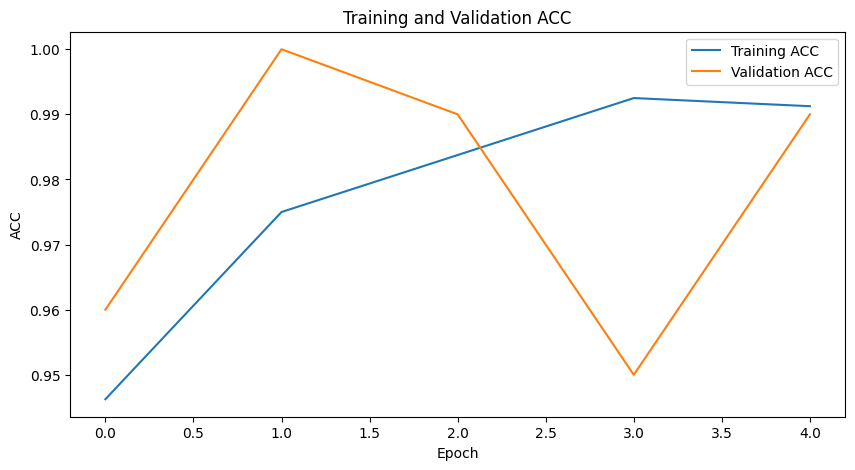

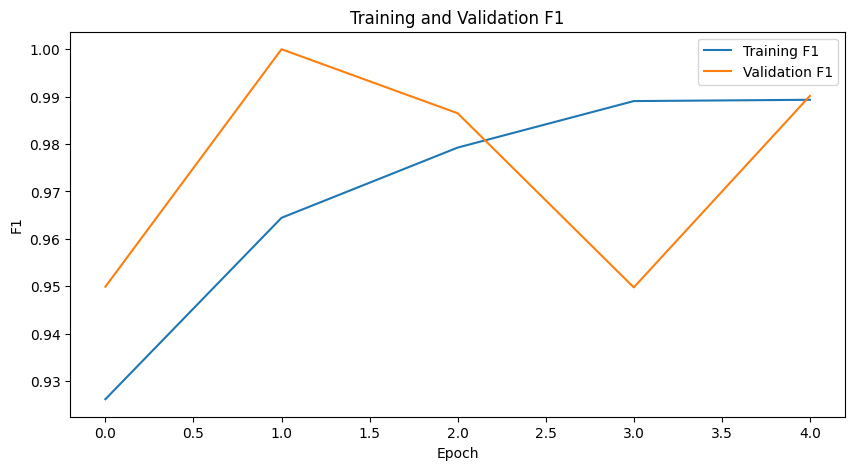

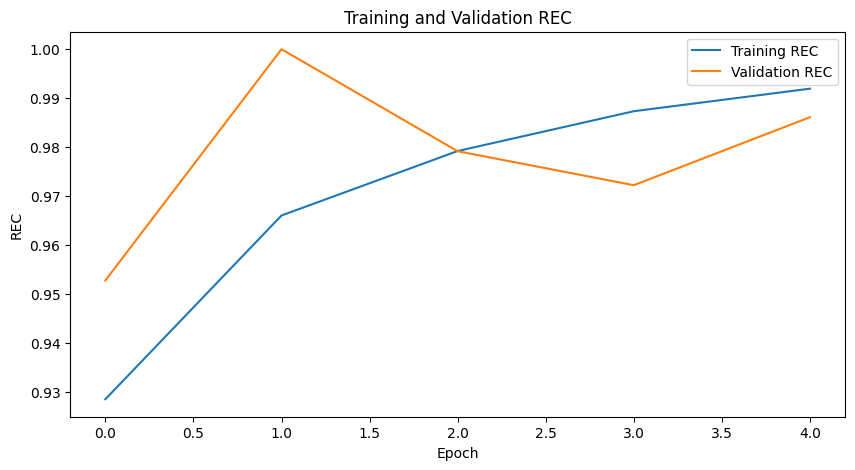

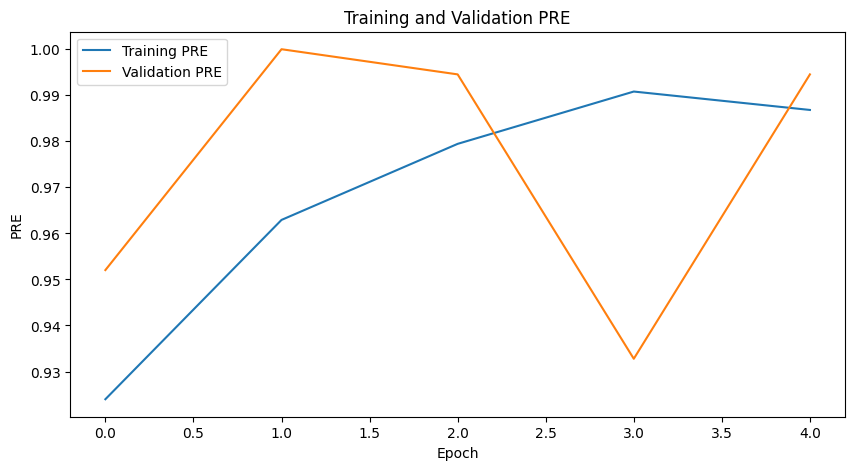

In [45]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Metrics
metric_names = list(train_metrics_list[0].keys())  # Assuming metrics have same keys for train and validation
for metric_name in metric_names:
    train_metric_values = [metrics[metric_name] for metrics in train_metrics_list]
    valid_metric_values = [metrics[metric_name] for metrics in valid_metrics_list]

    plt.figure(figsize=(10, 5))
    plt.plot(train_metric_values, label='Training ' + metric_name)
    plt.plot(valid_metric_values, label='Validation ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title('Training and Validation ' + metric_name)
    plt.legend()
    plt.show()

In [46]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 75%|███████▌  | 3/4 [00:01<00:00,  3.68it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
 

    index     label
0       0   neutral
1       1   neutral
2       2   neutral
3       3  negative
4       4   neutral
..    ...       ...
95     95  positive
96     96   neutral
97     97   neutral
98     98   neutral
99     99   neutral

[100 rows x 2 columns]


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

    index     label
0       0   neutral
1       1   neutral
2       2   neutral
3       3  negative
4       4   neutral
..    ...       ...
95     95  positive
96     96   neutral
97     97   neutral
98     98   neutral
99     99   neutral

[100 rows x 2 columns]


In [47]:
text = 'Motor listrik sangat bagus, tapi harganya mahal'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Motor listrik sangat bagus, tapi harganya mahal | Label : negative (68.620%)


# SVM

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

# Pra-pemrosesan data (sama seperti yang Anda lakukan sebelumnya)

# Konversi teks ke vektor fitur menggunakan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['sentiment']

# Inisialisasi dan latih model SVM
svm_model = svm.SVC(kernel='linear')  # Anda dapat memilih kernel yang sesuai
svm_model.fit(X_train, y_train)

# Evaluasi model pada data validasi
X_valid = tfidf_vectorizer.transform(valid_data['text'])
y_valid = valid_data['sentiment']
y_pred_valid = svm_model.predict(X_valid)

print("Classification Report on Validation Data:")
print(classification_report(y_valid, y_pred_valid))

# Evaluasi model pada data pengujian
X_test = tfidf_vectorizer.transform(test_data['text'])
y_test = test_data['sentiment']
y_pred_test = svm_model.predict(X_test)

print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Classification Report on Validation Data:
              precision    recall  f1-score   support

    negative       0.41      0.44      0.42        16
     neutral       0.79      0.95      0.86        60
    positive       1.00      0.46      0.63        24

    accuracy                           0.75       100
   macro avg       0.73      0.62      0.64       100
weighted avg       0.78      0.75      0.74       100

Classification Report on Test Data:
              precision    recall  f1-score   support

    negative       0.53      0.62      0.57        16
     neutral       0.83      0.90      0.86        58
    positive       0.89      0.62      0.73        26

    accuracy                           0.78       100
   macro avg       0.75      0.71      0.72       100
weighted avg       0.79      0.78      0.78       100

